## Imports

In [1]:
pip install Pillow

Note: you may need to restart the kernel to use updated packages.


---

In [1]:
import os
from PIL import Image
import numpy as np
from tqdm.notebook import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [2]:
fp_local = '/home/jovyan/docker/src/python/temp_test/DJGrad'
fp_data = os.path.join(fp_local, 'data')

In [4]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

num_classes = 3

In [8]:
from tensorflow import keras
from copy import deepcopy

class DistMLP(keras.Model):
    def __init__(self,):
        super(DistMLP, self).__init__()
        self.mod1 = Sequential([
            layers.Rescaling(1./255, input_shape=(*x.shape[1:],)),
            layers.Conv2D(16, 3, padding='same', activation='relu'),
            layers.MaxPooling2D(),
            layers.Conv2D(64, 3, padding='same', activation='relu'),
            layers.MaxPooling2D(),
            layers.Flatten(),
#             layers.Dropout(0.9),
            layers.Dense(128, activation='relu'),
            layers.Dense(num_classes, 'softmax')
        ])
        
        self.mod2 = tf.keras.models.clone_model(self.mod1)
        self.mod3 = tf.keras.models.clone_model(self.mod1)
#         self.mod4 = tf.keras.models.clone_model(self.mod1)

    def call(self, data):
        return self.mod1(data)

    def train_step(self, data):
        x,y = data
        with tf.GradientTape() as tape:
            y_pred1 = self.mod1(x,training=True)
            y_pred2 = self.mod2(x,training=True)
            y_pred3 = self.mod3(x,training=True)
#             y_pred4 = self.mod4(x,training=True)
            loss1 = self.compiled_loss(y,y_pred1)
            loss2 = self.compiled_loss(y,y_pred2)
            loss3 = self.compiled_loss(y,y_pred3)
#             loss4 = self.compiled_loss(y,y_pred4)

        grads = tape.gradient([loss1,loss2,loss3], self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.compiled_metrics.update_state(tf.concat([y,y,y],0), tf.concat([y_pred1,y_pred2,y_pred3],0))

        return {m.name: m.result() for m in self.metrics}

In [9]:
m = DistMLP()
m.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy'],
    run_eagerly=True
)

In [10]:
m.fit(
    train_dataset,
    epochs=10
)

Epoch 1/10


ResourceExhaustedError: OOM when allocating tensor with shape[1000000,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Fill]

---

## Try smaller Dataset

In [6]:
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

In [7]:
(x_train,y_train),(x_test,y_test) = tf.keras.datasets.mnist.load_data()

In [8]:
x_test.reshape(-1,28**2).shape

(10000, 784)

In [9]:
batch_size = 128

train_dataset = tf.data.Dataset.from_tensor_slices((x_train.reshape(60000,28**2),y_train)).shuffle(100).batch(batch_size,True)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test.reshape(10000,28**2),y_test)).shuffle(100).batch(batch_size,True)

In [10]:
model = Sequential([
    layers.Dense(1024, activation='relu', input_shape=(28**2,)),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(10, 'softmax')
])

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(
    ),
    metrics=['accuracy']
)

In [11]:
epochs=30
history = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=test_dataset
)

Epoch 1/30
468/468 [==============================] - 1s 3ms/step - loss: 2.1468 - accuracy: 0.4503 - val_loss: 1.3095 - val_accuracy: 0.5543
Epoch 2/30
468/468 [==============================] - 1s 3ms/step - loss: 1.1754 - accuracy: 0.5706 - val_loss: 1.0293 - val_accuracy: 0.6373
Epoch 3/30
468/468 [==============================] - 1s 2ms/step - loss: 0.9799 - accuracy: 0.6320 - val_loss: 0.9168 - val_accuracy: 0.6564
Epoch 4/30
468/468 [==============================] - 1s 2ms/step - loss: 0.7704 - accuracy: 0.7192 - val_loss: 0.6605 - val_accuracy: 0.8108
Epoch 5/30
468/468 [==============================] - 1s 2ms/step - loss: 0.4285 - accuracy: 0.8838 - val_loss: 0.3577 - val_accuracy: 0.9262
Epoch 6/30
468/468 [==============================] - 1s 2ms/step - loss: 0.2422 - accuracy: 0.9494 - val_loss: 0.2756 - val_accuracy: 0.9443
Epoch 7/30
468/468 [==============================] - 1s 3ms/step - loss: 0.1770 - accuracy: 0.9615 - val_loss: 0.2234 - val_accuracy: 0.9553
Epoch 

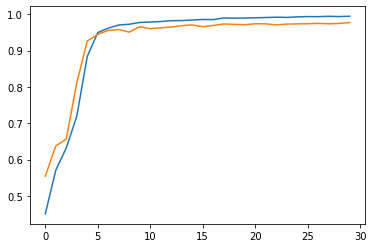

In [12]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.show()

---

## Custom model

In [13]:
from sklearn.utils import shuffle

split_by_type = [x_train[np.where(y_train==x)] for x in range(10)]
split_by_type = [x[:x.shape[0]//4*4].reshape(4,-1,28,28) for x in split_by_type]

ds1  = [split_by_type[0][0:2], split_by_type[1][0:2]]
ds2  = [split_by_type[2][0:2], split_by_type[3][0:2]]
ds3  = [split_by_type[4][0:2], split_by_type[5][0:2]]
ds4  = [split_by_type[6][0:2], split_by_type[7][0:2]]

y1   = [0 for _ in range(np.multiply(*split_by_type[0][0:2].shape[:2]))] + [1 for _ in range(np.multiply(*split_by_type[1][0:2].shape[:2]))]
y2   = [2 for _ in range(np.multiply(*split_by_type[2][0:2].shape[:2]))] + [3 for _ in range(np.multiply(*split_by_type[3][0:2].shape[:2]))]
y3   = [4 for _ in range(np.multiply(*split_by_type[4][0:2].shape[:2]))] + [5 for _ in range(np.multiply(*split_by_type[5][0:2].shape[:2]))]
y4   = [6 for _ in range(np.multiply(*split_by_type[6][0:2].shape[:2]))] + [7 for _ in range(np.multiply(*split_by_type[7][0:2].shape[:2]))]

##

ds1 += [split_by_type[2][2:3], split_by_type[3][2:3]]
ds2 += [split_by_type[4][2:3], split_by_type[5][2:3]]
ds3 += [split_by_type[6][2:3], split_by_type[7][2:3]]
ds4 += [split_by_type[0][2:3], split_by_type[1][2:3]]

y1  += [2 for _ in range(np.multiply(*split_by_type[2][2:3].shape[:2]))] + [3 for _ in range(np.multiply(*split_by_type[3][2:3].shape[:2]))]
y2  += [4 for _ in range(np.multiply(*split_by_type[4][2:3].shape[:2]))] + [5 for _ in range(np.multiply(*split_by_type[5][2:3].shape[:2]))]
y3  += [6 for _ in range(np.multiply(*split_by_type[6][2:3].shape[:2]))] + [7 for _ in range(np.multiply(*split_by_type[7][2:3].shape[:2]))]
y4  += [0 for _ in range(np.multiply(*split_by_type[0][2:3].shape[:2]))] + [1 for _ in range(np.multiply(*split_by_type[1][2:3].shape[:2]))]

##

ds1 += [split_by_type[4][3:4], split_by_type[5][3:4]]
ds2 += [split_by_type[6][3:4], split_by_type[7][3:4]]
ds3 += [split_by_type[0][3:4], split_by_type[1][3:4]]
ds4 += [split_by_type[2][3:4], split_by_type[3][3:4]]

y1  += [4 for _ in range(np.multiply(*split_by_type[4][3:4].shape[:2]))] + [5 for _ in range(np.multiply(*split_by_type[5][3:4].shape[:2]))]
y2  += [6 for _ in range(np.multiply(*split_by_type[6][3:4].shape[:2]))] + [7 for _ in range(np.multiply(*split_by_type[7][3:4].shape[:2]))]
y3  += [0 for _ in range(np.multiply(*split_by_type[0][3:4].shape[:2]))] + [1 for _ in range(np.multiply(*split_by_type[1][3:4].shape[:2]))]
y4  += [2 for _ in range(np.multiply(*split_by_type[2][3:4].shape[:2]))] + [3 for _ in range(np.multiply(*split_by_type[3][3:4].shape[:2]))]

##

ds1 += [split_by_type[8][0:1], split_by_type[9][0:1]]
ds2 += [split_by_type[8][1:2], split_by_type[9][1:2]]
ds3 += [split_by_type[8][2:3], split_by_type[9][2:3]]
ds4 += [split_by_type[8][3:4], split_by_type[9][3:4]]

y1  += [8 for _ in range(np.multiply(*split_by_type[8][0:1].shape[:2]))] + [9 for _ in range(np.multiply(*split_by_type[9][0:1].shape[:2]))]
y2  += [8 for _ in range(np.multiply(*split_by_type[8][1:2].shape[:2]))] + [9 for _ in range(np.multiply(*split_by_type[9][1:2].shape[:2]))]
y3  += [8 for _ in range(np.multiply(*split_by_type[8][2:3].shape[:2]))] + [9 for _ in range(np.multiply(*split_by_type[9][2:3].shape[:2]))]
y4  += [8 for _ in range(np.multiply(*split_by_type[8][3:4].shape[:2]))] + [9 for _ in range(np.multiply(*split_by_type[9][3:4].shape[:2]))]

##

ds1 = [list(x.reshape(-1,28,28)) for x in ds1]
ds2 = [list(x.reshape(-1,28,28)) for x in ds2]
ds3 = [list(x.reshape(-1,28,28)) for x in ds3]
ds4 = [list(x.reshape(-1,28,28)) for x in ds4]

##

ds1 = np.array([item for sublist in ds1 for item in sublist])
ds2 = np.array([item for sublist in ds2 for item in sublist])
ds3 = np.array([item for sublist in ds3 for item in sublist])
ds4 = np.array([item for sublist in ds4 for item in sublist])

y1 = np.array(y1)
y2 = np.array(y2)
y3 = np.array(y3)
y4 = np.array(y4)

##

ds1,y1 = shuffle(ds1,y1)
ds2,y2 = shuffle(ds2,y2)
ds3,y3 = shuffle(ds3,y3)
ds4,y4 = shuffle(ds4,y4)

##

m = min([x.shape[0] for x in [ds1,ds2,ds3,ds4]])

ds1,y1 = ds1[:m].reshape(-1,28**2),y1[:m]
ds2,y2 = ds2[:m].reshape(-1,28**2),y2[:m]
ds3,y3 = ds3[:m].reshape(-1,28**2),y3[:m]
ds4,y4 = ds4[:m].reshape(-1,28**2),y4[:m]

##

x_test = x_test.reshape(-1,28**2)
train_dataset = tf.data.Dataset.from_tensor_slices((ds1,y1,ds2,y2,ds3,y3,ds4,y4)).shuffle(100).batch(batch_size,True)
validation_dataset= tf.data.Dataset.from_tensor_slices((x_test,y_test,x_test,y_test,x_test,y_test,x_test,y_test)).shuffle(100).batch(batch_size,True)

(array([1440., 1635., 1455., 1492.,    0.,    0., 2873., 3023., 1421.,
        1450.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

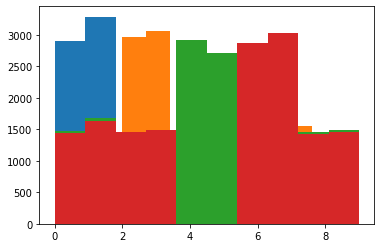

In [16]:
plt.hist(y1)
plt.hist(y2)
plt.hist(y3)
plt.hist(y4)

In [414]:
import hashlib


class Car():
    def __init__(self,neighbors,):
        self.neighbors = neighbors
        self.fwd_q = []
        self.rec_grad = set()
        self.new_grad = []
        
    def forward(self,lst_cars,):
        for n,c in enumerate(lst_cars):
            if n in self.neighbors:
                print(1)
                for grad in self.fwd_q:
                    c.receive(grad)
        
    def already_rec(self,grad,):
        bts = str(grad).encode('utf-8')#tf.io.serialize_tensor(grad)
        hashed = hashlib.sha256(bts).digest()
        
        if hashed in self.rec_grad:
            return (True,hashed)
        else:
            return (False,hashed)
        
    def apply_grad(self,grad,hashed,target,):
        self.rec_grad.add(hashed)
        return tf.math.add(target,grad)
    
    def apply_grads(self,target,):
        self.fwd_q=[]
        for g in self.new_grad:
            bl,hashed = self.already_rec(g)
            if not bl:
                target = self.apply_grad(g,hashed,target)
                self.fwd_q.append(g)
#                 self.roc_grad.add(hashed)
#                 np.math.add(target,grad)
        self.new_grad=[]
        return target
    
    def receive(self,grad,):
        self.new_grad.append(grad)
        

lst_cars = [
    Car([1]),
    Car([0])
]

In [420]:
lst_cars[0].receive(tf.ones(10)*2)
lst_cars[1].receive(tf.ones(10)*3)
lst_cars[1].receive(tf.ones(10)*5)

lst_cars[0].apply_grads(tf.ones(10)*7)
lst_cars[0].forward(lst_cars)

lst_cars[1].apply_grads(tf.ones(10)*11)

1


<tf.Tensor: shape=(10,), dtype=float32, numpy=array([21., 21., 21., 21., 21., 21., 21., 21., 21., 21.], dtype=float32)>

In [421]:
lst_cars[1].fwd_q

[<tf.Tensor: shape=(10,), dtype=float32, numpy=array([3., 3., 3., 3., 3., 3., 3., 3., 3., 3.], dtype=float32)>,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=array([5., 5., 5., 5., 5., 5., 5., 5., 5., 5.], dtype=float32)>,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=array([2., 2., 2., 2., 2., 2., 2., 2., 2., 2.], dtype=float32)>]

In [281]:
from tensorflow import keras
from copy import deepcopy
import tensorflow.experimental.numpy as tnp

def gen_mask(grads,m=2):
    mask = []
    for g in grads:
        size = g.shape[0]
        assert m%1==0

        split = tf.concat([tf.ones(size//m)*i for i in range(m)],0)
        split = tf.random.shuffle(split)
        mask.append(tf.reshape(split,(-1,1)))

    return mask

class DistMLP(keras.Model):
    def __init__(self,mode='none'):
        super(DistMLP, self).__init__()
        self.mod1 = Sequential([
            layers.Dense(1024, activation='relu', input_shape=(28**2,)),
            layers.Dense(32, activation='relu'),
            layers.Dense(16, activation='relu'),
            layers.Dropout(0.3),
            layers.Dense(10, 'softmax')
        ])
        
        self.mod2 = tf.keras.models.clone_model(self.mod1)
        self.mod3 = tf.keras.models.clone_model(self.mod1)
        self.mod4 = tf.keras.models.clone_model(self.mod1)
        
        self.mode=mode
        
#         self.edges = [(0,1),(1,2),(2,3),(3,0),]
        self.cars = [Car[i%2] for i in range(1,5)]
        self.gradients = []
#         self.seen_gradients = [set(),set(),set(),set()]

    def call(self, data):
        return self.mod1(data)

    def train_step(self, data):
        x1,y1,x2,y2,x3,y3,x4,y4, = data
        with tf.GradientTape() as tape:
            y_pred1 = self.mod1(x1,training=True)
            y_pred2 = self.mod2(x2,training=True)
            y_pred3 = self.mod3(x3,training=True)
            y_pred4 = self.mod4(x4,training=True)
            loss1 = self.compiled_loss(y1,y_pred1)
            loss2 = self.compiled_loss(y2,y_pred2)
            loss3 = self.compiled_loss(y3,y_pred3)
            loss4 = self.compiled_loss(y4,y_pred4)

        grads = tape.gradient([loss1,loss2,loss3,loss4], self.trainable_weights)
        
        if self.mode=='none':
            self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        elif self.mode=='simple_add':
            temp = [tf.math.add_n([grads[n+i*(len(grads)//4)] for i in range(4)]) for n in range(len(grads)//4)]
            self.optimizer.apply_gradients(zip([*temp,*temp,*temp,*temp], self.trainable_weights))
        elif self.mode=='djgrad':
#             new_grads = []
#             self.gradients.insert(0,[[],[],[],[]])
#             if len(self.gradients)>4:
#                 self.gradients = self.gradients[:-1]
            
            grad_mask = gen_mask(grads)
            
            for c in self.cars:
#                 lst_masked_grads = []
#                 lst_forwarded_grads = []
                for n in range(len(grads)//4):
                    
#                     main_gi = n+s[0]*(len(grads)//4)
#                     other_gi = n+s[1]*(len(grads)//4)
#                     masked_grads = tf.math.multiply(
#                             grads[other_gi],
#                             tf.reshape(grad_mask[other_gi],(-1,)) if len(grads[other_gi].shape)==1 else grad_mask[other_gi]
#                         )
                    
#                     lst_masked_grads.append(masked_grads)
#                     if len(self.gradients)>1 and len(self.gradients[1][s[1]])==2:
#                         if len(self.gradients[1][s[1]][1])>0:
#                             if np.random.random()>0.2:
#                                 masked_grads = tf.math.add(masked_grads,self.gradients[1][s[1]][1][n])
#                         lst_forwarded_grads.append(self.gradients[1][s[1]][0][n])

#                     new_grads.append(tf.math.add_n([
#                         grads[main_gi], # original model
#                         masked_grads # model receiving data from
#                     ]))
    
#                 self.gradients[0][s[0]].append(lst_masked_grads)
#                 self.gradients[0][s[0]].append(lst_forwarded_grads)
                            
            self.optimizer.apply_gradients(zip(
                new_grads,
                self.trainable_weights))
        
        # Need a metric that gives accuracy for each model individually
        self.compiled_metrics.update_state(tf.concat([y1,y2,y3,y4],0), tf.concat([y_pred1,y_pred2,y_pred3,y_pred4],0))

        return {m.name: m.result() for m in self.metrics}
    
    def test_step(self, data):
        x, y = data
        
        y_pred1 = self.mod1(x,training=False)
        y_pred2 = self.mod2(x,training=False)
        y_pred3 = self.mod3(x,training=False)
        y_pred4 = self.mod4(x,training=False)
        
        self.compiled_loss(tf.concat([y,y,y,y,],0),tf.concat([y_pred1,y_pred2,y_pred3,y_pred4],0))
        self.compiled_metrics.update_state(tf.concat([y,y,y,y],0),tf.concat([y_pred1,y_pred2,y_pred3,y_pred4],0))

        return {m.name: m.result() for m in self.metrics}

In [282]:
tf.random.set_seed(0)

m = DistMLP('djgrad')
m.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy'],
    run_eagerly=True
)

history = m.fit(
    train_dataset,
    epochs=100,
    validation_data=test_dataset
)

Epoch 1/100
115/115 [==============================] - 6s 52ms/step - loss: 3.7337 - accuracy: 0.2935 - val_loss: 2.1416 - val_accuracy: 0.2635
Epoch 2/100
115/115 [==============================] - 6s 53ms/step - loss: 1.8244 - accuracy: 0.3599 - val_loss: 2.0252 - val_accuracy: 0.2724
Epoch 3/100
115/115 [==============================] - 6s 53ms/step - loss: 1.7135 - accuracy: 0.3954 - val_loss: 2.1154 - val_accuracy: 0.2934
Epoch 4/100
115/115 [==============================] - 6s 52ms/step - loss: 1.6882 - accuracy: 0.3977 - val_loss: 1.9792 - val_accuracy: 0.3003
Epoch 5/100
115/115 [==============================] - 6s 52ms/step - loss: 1.6013 - accuracy: 0.4254 - val_loss: 2.0592 - val_accuracy: 0.3510
Epoch 6/100
115/115 [==============================] - 6s 51ms/step - loss: 1.5511 - accuracy: 0.4421 - val_loss: 2.0249 - val_accuracy: 0.3338
Epoch 7/100
115/115 [==============================] - 6s 51ms/step - loss: 1.5061 - accuracy: 0.4572 - val_loss: 2.1359 - val_accuracy:

KeyboardInterrupt: 

In [259]:
tf.random.set_seed(0)

m = DistMLP('none')
m.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy'],
    run_eagerly=True
)

history = m.fit(
    train_dataset,
    epochs=300,
    validation_data=test_dataset
)

Epoch 1/300
115/115 [==============================] - 4s 35ms/step - loss: 3.8043 - accuracy: 0.3222 - val_loss: 1.9565 - val_accuracy: 0.2872
Epoch 2/300
115/115 [==============================] - 4s 35ms/step - loss: 1.7270 - accuracy: 0.3944 - val_loss: 2.0787 - val_accuracy: 0.3589
Epoch 3/300
115/115 [==============================] - 4s 35ms/step - loss: 1.6235 - accuracy: 0.4343 - val_loss: 2.0723 - val_accuracy: 0.3557
Epoch 4/300
115/115 [==============================] - 4s 34ms/step - loss: 1.5608 - accuracy: 0.4480 - val_loss: 1.9192 - val_accuracy: 0.3845
Epoch 5/300
115/115 [==============================] - 4s 34ms/step - loss: 1.5083 - accuracy: 0.4632 - val_loss: 1.8369 - val_accuracy: 0.4069
Epoch 6/300
115/115 [==============================] - 4s 34ms/step - loss: 1.4486 - accuracy: 0.4824 - val_loss: 2.0461 - val_accuracy: 0.4198
Epoch 7/300
115/115 [==============================] - 4s 35ms/step - loss: 1.3713 - accuracy: 0.5040 - val_loss: 2.0156 - val_accuracy:

115/115 [==============================] - 4s 34ms/step - loss: 0.6295 - accuracy: 0.7734 - val_loss: 2.8120 - val_accuracy: 0.6271
Epoch 58/300
115/115 [==============================] - 4s 34ms/step - loss: 0.6338 - accuracy: 0.7732 - val_loss: 2.8792 - val_accuracy: 0.6250
Epoch 59/300
115/115 [==============================] - 4s 34ms/step - loss: 0.6251 - accuracy: 0.7740 - val_loss: 2.9505 - val_accuracy: 0.6272
Epoch 60/300
115/115 [==============================] - 4s 34ms/step - loss: 0.6116 - accuracy: 0.7777 - val_loss: 3.0307 - val_accuracy: 0.6286
Epoch 61/300
115/115 [==============================] - 4s 34ms/step - loss: 0.6144 - accuracy: 0.7778 - val_loss: 2.8377 - val_accuracy: 0.6277
Epoch 62/300
115/115 [==============================] - 4s 34ms/step - loss: 0.6011 - accuracy: 0.7816 - val_loss: 2.9784 - val_accuracy: 0.6269
Epoch 63/300
115/115 [==============================] - 4s 34ms/step - loss: 0.6014 - accuracy: 0.7835 - val_loss: 2.9789 - val_accuracy: 0.627

115/115 [==============================] - 4s 34ms/step - loss: 0.5087 - accuracy: 0.8163 - val_loss: 3.2067 - val_accuracy: 0.6320
Epoch 114/300
115/115 [==============================] - 4s 34ms/step - loss: 0.5048 - accuracy: 0.8174 - val_loss: 3.2153 - val_accuracy: 0.6330
Epoch 115/300
115/115 [==============================] - 4s 34ms/step - loss: 0.5077 - accuracy: 0.8169 - val_loss: 3.2031 - val_accuracy: 0.6321
Epoch 116/300
115/115 [==============================] - 4s 34ms/step - loss: 0.5230 - accuracy: 0.8140 - val_loss: 3.1745 - val_accuracy: 0.6313
Epoch 117/300
115/115 [==============================] - 4s 34ms/step - loss: 0.5006 - accuracy: 0.8187 - val_loss: 3.1952 - val_accuracy: 0.6340
Epoch 118/300
115/115 [==============================] - 4s 34ms/step - loss: 0.4992 - accuracy: 0.8199 - val_loss: 3.1948 - val_accuracy: 0.6337
Epoch 119/300
115/115 [==============================] - 4s 34ms/step - loss: 0.5012 - accuracy: 0.8192 - val_loss: 3.1898 - val_accuracy:

115/115 [==============================] - 4s 34ms/step - loss: 0.4808 - accuracy: 0.8234 - val_loss: 3.4113 - val_accuracy: 0.6297
Epoch 170/300
115/115 [==============================] - 4s 34ms/step - loss: 0.4921 - accuracy: 0.8224 - val_loss: 3.3316 - val_accuracy: 0.6302
Epoch 171/300
115/115 [==============================] - 4s 34ms/step - loss: 0.4826 - accuracy: 0.8239 - val_loss: 3.3779 - val_accuracy: 0.6330
Epoch 172/300
115/115 [==============================] - 4s 34ms/step - loss: 0.4799 - accuracy: 0.8247 - val_loss: 3.3770 - val_accuracy: 0.6343
Epoch 173/300
115/115 [==============================] - 4s 34ms/step - loss: 0.4754 - accuracy: 0.8264 - val_loss: 3.3918 - val_accuracy: 0.6348
Epoch 174/300
115/115 [==============================] - 4s 34ms/step - loss: 0.4749 - accuracy: 0.8271 - val_loss: 3.3616 - val_accuracy: 0.6338
Epoch 175/300
115/115 [==============================] - 4s 34ms/step - loss: 0.4677 - accuracy: 0.8277 - val_loss: 3.3797 - val_accuracy:

115/115 [==============================] - 4s 33ms/step - loss: 0.4582 - accuracy: 0.8299 - val_loss: 3.5849 - val_accuracy: 0.6350
Epoch 226/300
115/115 [==============================] - 4s 34ms/step - loss: 0.4522 - accuracy: 0.8321 - val_loss: 3.5853 - val_accuracy: 0.6352
Epoch 227/300
115/115 [==============================] - 4s 34ms/step - loss: 0.4533 - accuracy: 0.8318 - val_loss: 3.6240 - val_accuracy: 0.6341
Epoch 228/300
115/115 [==============================] - 4s 34ms/step - loss: 0.4526 - accuracy: 0.8329 - val_loss: 3.6086 - val_accuracy: 0.6338
Epoch 229/300
115/115 [==============================] - 4s 34ms/step - loss: 0.4739 - accuracy: 0.8299 - val_loss: 3.6207 - val_accuracy: 0.6328
Epoch 230/300
115/115 [==============================] - 4s 34ms/step - loss: 0.4673 - accuracy: 0.8295 - val_loss: 3.6254 - val_accuracy: 0.6315
Epoch 231/300
115/115 [==============================] - 4s 34ms/step - loss: 0.4656 - accuracy: 0.8291 - val_loss: 3.5888 - val_accuracy:

115/115 [==============================] - 4s 33ms/step - loss: 0.4524 - accuracy: 0.8329 - val_loss: 3.7066 - val_accuracy: 0.6338
Epoch 282/300
115/115 [==============================] - 4s 34ms/step - loss: 0.4528 - accuracy: 0.8330 - val_loss: 3.6990 - val_accuracy: 0.6347
Epoch 283/300
115/115 [==============================] - 4s 33ms/step - loss: 0.4470 - accuracy: 0.8342 - val_loss: 3.7024 - val_accuracy: 0.6348
Epoch 284/300
115/115 [==============================] - 4s 34ms/step - loss: 0.4510 - accuracy: 0.8338 - val_loss: 3.7169 - val_accuracy: 0.6339
Epoch 285/300
115/115 [==============================] - 4s 33ms/step - loss: 0.4536 - accuracy: 0.8324 - val_loss: 3.7180 - val_accuracy: 0.6333
Epoch 286/300
115/115 [==============================] - 4s 33ms/step - loss: 0.4461 - accuracy: 0.8337 - val_loss: 3.7194 - val_accuracy: 0.6341
Epoch 287/300
115/115 [==============================] - 4s 33ms/step - loss: 0.4508 - accuracy: 0.8332 - val_loss: 3.7166 - val_accuracy:

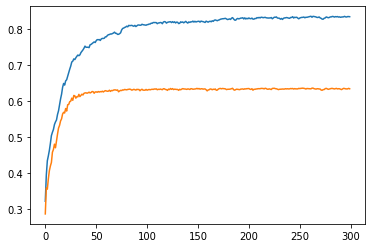

In [260]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.show()

In [261]:
tf.random.set_seed(0)

m = DistMLP('simple_add')
m.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy'],
    run_eagerly=True
)

history = m.fit(
    train_dataset,
    epochs=300,
    validation_data=test_dataset
)

Epoch 1/300
115/115 [==============================] - 4s 36ms/step - loss: 3.8987 - accuracy: 0.2592 - val_loss: 2.0182 - val_accuracy: 0.2492
Epoch 2/300
115/115 [==============================] - 4s 36ms/step - loss: 1.8627 - accuracy: 0.3144 - val_loss: 1.8835 - val_accuracy: 0.3393
Epoch 3/300
115/115 [==============================] - 4s 36ms/step - loss: 1.7275 - accuracy: 0.3690 - val_loss: 1.9299 - val_accuracy: 0.3279
Epoch 4/300
115/115 [==============================] - 4s 36ms/step - loss: 1.6082 - accuracy: 0.4255 - val_loss: 1.9463 - val_accuracy: 0.3616
Epoch 5/300
115/115 [==============================] - 4s 36ms/step - loss: 1.5139 - accuracy: 0.4604 - val_loss: 1.8006 - val_accuracy: 0.4013
Epoch 6/300
115/115 [==============================] - 4s 36ms/step - loss: 1.4246 - accuracy: 0.4934 - val_loss: 1.8772 - val_accuracy: 0.4454
Epoch 7/300
115/115 [==============================] - 4s 36ms/step - loss: 1.3567 - accuracy: 0.5299 - val_loss: 1.7997 - val_accuracy:

115/115 [==============================] - 4s 35ms/step - loss: 0.5298 - accuracy: 0.8185 - val_loss: 2.2233 - val_accuracy: 0.7092
Epoch 58/300
115/115 [==============================] - 4s 35ms/step - loss: 0.5187 - accuracy: 0.8201 - val_loss: 2.3289 - val_accuracy: 0.7023
Epoch 59/300
115/115 [==============================] - 4s 35ms/step - loss: 0.5219 - accuracy: 0.8186 - val_loss: 2.1656 - val_accuracy: 0.7120
Epoch 60/300
115/115 [==============================] - 4s 35ms/step - loss: 0.5039 - accuracy: 0.8236 - val_loss: 2.4124 - val_accuracy: 0.7049
Epoch 61/300
115/115 [==============================] - 4s 35ms/step - loss: 0.5041 - accuracy: 0.8256 - val_loss: 2.2929 - val_accuracy: 0.7024
Epoch 62/300
115/115 [==============================] - 4s 35ms/step - loss: 0.4838 - accuracy: 0.8290 - val_loss: 2.4127 - val_accuracy: 0.7062
Epoch 63/300
115/115 [==============================] - 4s 35ms/step - loss: 0.4886 - accuracy: 0.8304 - val_loss: 2.4149 - val_accuracy: 0.710

115/115 [==============================] - 4s 35ms/step - loss: 0.3771 - accuracy: 0.8687 - val_loss: 2.9566 - val_accuracy: 0.7227
Epoch 114/300
115/115 [==============================] - 4s 35ms/step - loss: 0.3743 - accuracy: 0.8701 - val_loss: 3.0628 - val_accuracy: 0.7197
Epoch 115/300
115/115 [==============================] - 4s 35ms/step - loss: 0.3751 - accuracy: 0.8722 - val_loss: 2.9901 - val_accuracy: 0.7207
Epoch 116/300
115/115 [==============================] - 4s 35ms/step - loss: 0.3793 - accuracy: 0.8682 - val_loss: 2.9067 - val_accuracy: 0.7266
Epoch 117/300
115/115 [==============================] - 4s 35ms/step - loss: 0.3514 - accuracy: 0.8772 - val_loss: 2.9242 - val_accuracy: 0.7250
Epoch 118/300
115/115 [==============================] - 4s 35ms/step - loss: 0.3536 - accuracy: 0.8749 - val_loss: 2.8208 - val_accuracy: 0.7241
Epoch 119/300
115/115 [==============================] - 4s 35ms/step - loss: 0.3502 - accuracy: 0.8769 - val_loss: 2.9289 - val_accuracy:

115/115 [==============================] - 4s 35ms/step - loss: 0.3177 - accuracy: 0.8860 - val_loss: 2.9539 - val_accuracy: 0.7222
Epoch 170/300
115/115 [==============================] - 4s 35ms/step - loss: 0.3242 - accuracy: 0.8842 - val_loss: 3.0157 - val_accuracy: 0.7244
Epoch 171/300
115/115 [==============================] - 4s 35ms/step - loss: 0.3098 - accuracy: 0.8861 - val_loss: 2.8579 - val_accuracy: 0.7249
Epoch 172/300
115/115 [==============================] - 4s 35ms/step - loss: 0.3092 - accuracy: 0.8836 - val_loss: 3.0065 - val_accuracy: 0.7267
Epoch 173/300
115/115 [==============================] - 4s 35ms/step - loss: 0.3095 - accuracy: 0.8882 - val_loss: 3.0691 - val_accuracy: 0.7230
Epoch 174/300
115/115 [==============================] - 4s 35ms/step - loss: 0.3325 - accuracy: 0.8837 - val_loss: 2.9079 - val_accuracy: 0.7259
Epoch 175/300
115/115 [==============================] - 4s 35ms/step - loss: 0.3128 - accuracy: 0.8857 - val_loss: 3.0385 - val_accuracy:

115/115 [==============================] - 4s 35ms/step - loss: 0.2951 - accuracy: 0.8907 - val_loss: 3.0518 - val_accuracy: 0.7275
Epoch 226/300
115/115 [==============================] - 4s 35ms/step - loss: 0.2849 - accuracy: 0.8921 - val_loss: 2.9357 - val_accuracy: 0.7334
Epoch 227/300
115/115 [==============================] - 4s 35ms/step - loss: 0.2845 - accuracy: 0.8927 - val_loss: 3.0021 - val_accuracy: 0.7274
Epoch 228/300
115/115 [==============================] - 4s 35ms/step - loss: 0.2955 - accuracy: 0.8919 - val_loss: 3.0538 - val_accuracy: 0.7252
Epoch 229/300
115/115 [==============================] - 4s 35ms/step - loss: 0.2930 - accuracy: 0.8901 - val_loss: 3.0061 - val_accuracy: 0.7283
Epoch 230/300
115/115 [==============================] - 4s 35ms/step - loss: 0.2870 - accuracy: 0.8923 - val_loss: 3.0244 - val_accuracy: 0.7270
Epoch 231/300
115/115 [==============================] - 4s 35ms/step - loss: 0.2963 - accuracy: 0.8899 - val_loss: 2.9576 - val_accuracy:

115/115 [==============================] - 4s 35ms/step - loss: 0.2772 - accuracy: 0.8936 - val_loss: 2.9825 - val_accuracy: 0.7308
Epoch 282/300
115/115 [==============================] - 4s 36ms/step - loss: 0.2733 - accuracy: 0.8922 - val_loss: 3.0356 - val_accuracy: 0.7310
Epoch 283/300
115/115 [==============================] - 4s 35ms/step - loss: 0.2853 - accuracy: 0.8937 - val_loss: 2.9710 - val_accuracy: 0.7319
Epoch 284/300
115/115 [==============================] - 4s 36ms/step - loss: 0.2953 - accuracy: 0.8905 - val_loss: 2.9880 - val_accuracy: 0.7321
Epoch 285/300
115/115 [==============================] - 4s 36ms/step - loss: 0.3034 - accuracy: 0.8900 - val_loss: 3.0374 - val_accuracy: 0.7348
Epoch 286/300
115/115 [==============================] - 4s 35ms/step - loss: 0.2928 - accuracy: 0.8897 - val_loss: 3.0619 - val_accuracy: 0.7300
Epoch 287/300
115/115 [==============================] - 4s 36ms/step - loss: 0.2705 - accuracy: 0.8942 - val_loss: 3.0169 - val_accuracy:

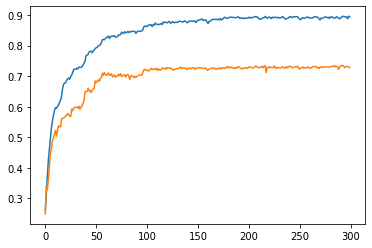

In [262]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.show()

In [263]:
tf.random.set_seed(0)

m = DistMLP('djgrad')
m.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy'],
    run_eagerly=True
)

history = m.fit(
    train_dataset,
    epochs=300,
    validation_data=test_dataset
)

Epoch 1/300
115/115 [==============================] - 6s 53ms/step - loss: 3.8740 - accuracy: 0.2792 - val_loss: 1.9559 - val_accuracy: 0.2710
Epoch 2/300
115/115 [==============================] - 6s 53ms/step - loss: 1.8209 - accuracy: 0.3640 - val_loss: 1.8863 - val_accuracy: 0.3009
Epoch 3/300
115/115 [==============================] - 6s 52ms/step - loss: 1.7101 - accuracy: 0.3831 - val_loss: 1.8648 - val_accuracy: 0.3225
Epoch 4/300
115/115 [==============================] - 6s 52ms/step - loss: 1.6417 - accuracy: 0.4038 - val_loss: 1.7532 - val_accuracy: 0.3633
Epoch 5/300
115/115 [==============================] - 6s 52ms/step - loss: 1.5430 - accuracy: 0.4376 - val_loss: 1.8644 - val_accuracy: 0.3764
Epoch 6/300
115/115 [==============================] - 6s 52ms/step - loss: 1.4732 - accuracy: 0.4612 - val_loss: 1.8763 - val_accuracy: 0.3813
Epoch 7/300
115/115 [==============================] - 6s 52ms/step - loss: 1.4324 - accuracy: 0.4725 - val_loss: 1.8666 - val_accuracy:

115/115 [==============================] - 6s 51ms/step - loss: 0.3294 - accuracy: 0.9016 - val_loss: 2.9254 - val_accuracy: 0.7666
Epoch 58/300
115/115 [==============================] - 6s 52ms/step - loss: 0.3287 - accuracy: 0.9032 - val_loss: 2.9980 - val_accuracy: 0.7683
Epoch 59/300
115/115 [==============================] - 6s 51ms/step - loss: 0.3374 - accuracy: 0.8989 - val_loss: 2.9652 - val_accuracy: 0.7668
Epoch 60/300
115/115 [==============================] - 6s 52ms/step - loss: 0.3302 - accuracy: 0.8997 - val_loss: 2.9106 - val_accuracy: 0.7675
Epoch 61/300
115/115 [==============================] - 6s 51ms/step - loss: 0.3142 - accuracy: 0.9046 - val_loss: 2.9987 - val_accuracy: 0.7683
Epoch 62/300
115/115 [==============================] - 6s 51ms/step - loss: 0.3172 - accuracy: 0.9055 - val_loss: 2.9659 - val_accuracy: 0.7676
Epoch 63/300
115/115 [==============================] - 6s 51ms/step - loss: 0.3348 - accuracy: 0.9018 - val_loss: 2.9210 - val_accuracy: 0.767

115/115 [==============================] - 6s 52ms/step - loss: 0.2134 - accuracy: 0.9379 - val_loss: 3.1179 - val_accuracy: 0.7740
Epoch 114/300
115/115 [==============================] - 6s 53ms/step - loss: 0.2073 - accuracy: 0.9414 - val_loss: 3.0801 - val_accuracy: 0.7722
Epoch 115/300
115/115 [==============================] - 6s 53ms/step - loss: 0.2129 - accuracy: 0.9435 - val_loss: 3.0850 - val_accuracy: 0.7738
Epoch 116/300
115/115 [==============================] - 6s 52ms/step - loss: 0.1963 - accuracy: 0.9447 - val_loss: 3.1561 - val_accuracy: 0.7722
Epoch 117/300
115/115 [==============================] - 6s 52ms/step - loss: 0.2174 - accuracy: 0.9408 - val_loss: 3.0996 - val_accuracy: 0.7711
Epoch 118/300
115/115 [==============================] - 6s 52ms/step - loss: 0.2085 - accuracy: 0.9394 - val_loss: 3.1144 - val_accuracy: 0.7728
Epoch 119/300
115/115 [==============================] - 6s 52ms/step - loss: 0.2020 - accuracy: 0.9416 - val_loss: 3.0743 - val_accuracy:

115/115 [==============================] - 6s 52ms/step - loss: 0.1959 - accuracy: 0.9469 - val_loss: 3.1945 - val_accuracy: 0.7695
Epoch 170/300
115/115 [==============================] - 6s 53ms/step - loss: 0.1842 - accuracy: 0.9483 - val_loss: 3.1928 - val_accuracy: 0.7736
Epoch 171/300
115/115 [==============================] - 6s 52ms/step - loss: 0.1967 - accuracy: 0.9466 - val_loss: 3.1445 - val_accuracy: 0.7739
Epoch 172/300
115/115 [==============================] - 6s 52ms/step - loss: 0.1977 - accuracy: 0.9466 - val_loss: 3.0795 - val_accuracy: 0.7711
Epoch 173/300
115/115 [==============================] - 6s 52ms/step - loss: 0.1849 - accuracy: 0.9485 - val_loss: 3.0523 - val_accuracy: 0.7727
Epoch 174/300
115/115 [==============================] - 6s 52ms/step - loss: 0.2072 - accuracy: 0.9500 - val_loss: 3.0282 - val_accuracy: 0.7709
Epoch 175/300
115/115 [==============================] - 6s 53ms/step - loss: 0.1838 - accuracy: 0.9497 - val_loss: 3.1254 - val_accuracy:

115/115 [==============================] - 6s 53ms/step - loss: 0.1596 - accuracy: 0.9541 - val_loss: 3.1040 - val_accuracy: 0.7746
Epoch 226/300
115/115 [==============================] - 6s 52ms/step - loss: 0.1556 - accuracy: 0.9543 - val_loss: 3.1804 - val_accuracy: 0.7755
Epoch 227/300
115/115 [==============================] - 6s 52ms/step - loss: 0.1543 - accuracy: 0.9551 - val_loss: 3.0771 - val_accuracy: 0.7756
Epoch 228/300
115/115 [==============================] - 6s 52ms/step - loss: 0.1630 - accuracy: 0.9544 - val_loss: 3.2331 - val_accuracy: 0.7740
Epoch 229/300
115/115 [==============================] - 6s 52ms/step - loss: 0.1609 - accuracy: 0.9545 - val_loss: 3.1495 - val_accuracy: 0.7747
Epoch 230/300
115/115 [==============================] - 6s 52ms/step - loss: 0.1511 - accuracy: 0.9550 - val_loss: 3.1324 - val_accuracy: 0.7763
Epoch 231/300
115/115 [==============================] - 6s 52ms/step - loss: 0.1559 - accuracy: 0.9558 - val_loss: 3.1001 - val_accuracy:

115/115 [==============================] - 6s 53ms/step - loss: 0.1602 - accuracy: 0.9551 - val_loss: 3.2481 - val_accuracy: 0.7731
Epoch 282/300
115/115 [==============================] - 6s 52ms/step - loss: 0.1559 - accuracy: 0.9563 - val_loss: 3.2312 - val_accuracy: 0.7746
Epoch 283/300
115/115 [==============================] - 6s 52ms/step - loss: 0.1453 - accuracy: 0.9580 - val_loss: 3.3052 - val_accuracy: 0.7731
Epoch 284/300
115/115 [==============================] - 6s 52ms/step - loss: 0.1935 - accuracy: 0.9473 - val_loss: 3.2699 - val_accuracy: 0.7672
Epoch 285/300
115/115 [==============================] - 6s 52ms/step - loss: 0.1834 - accuracy: 0.9461 - val_loss: 3.2462 - val_accuracy: 0.7695
Epoch 286/300
115/115 [==============================] - 6s 51ms/step - loss: 0.1815 - accuracy: 0.9484 - val_loss: 3.2463 - val_accuracy: 0.7716
Epoch 287/300
115/115 [==============================] - 6s 52ms/step - loss: 0.1791 - accuracy: 0.9516 - val_loss: 3.2839 - val_accuracy:

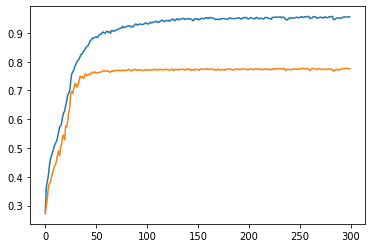

In [264]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.show()

In [126]:
grads = [tf.random.uniform(((x+1)*2,)) for x in range(10)]

In [133]:
def gen_mask(grads):
    mask = []
    for g in grads:
        size = g.shape[0]
        m = 2
        assert m%1==0

        split = tf.concat([tf.ones(size//m)*i for i in range(m)],0)
        split = tf.random.shuffle(split)
        mask.append(tf.reshape(split,(1,-1)))

    return mask
    
res = gen_mask(grads)
print(res[2])
tf.math.multiply(res[2],grads[2])

tf.Tensor([[1. 0. 1. 0. 0. 1.]], shape=(1, 6), dtype=float32)


<tf.Tensor: shape=(1, 6), dtype=float32, numpy=
array([[0.21151745, 0.        , 0.855551  , 0.        , 0.        ,
        0.26175773]], dtype=float32)>

### Car
#### Variables
- queue: forwarding queue (gradients to forward)
- set: gradients received (prevents from reapplying the same gradients multiple times)
    - use the [hash](https://gist.github.com/nmalkin/e287f71788c57fd71bd0a7eec9345add) on [bytes](https://stackoverflow.com/questions/67076522/how-to-convert-tensorflow-tensor-to-bytes)
- list: neighbors (cars it can share with)
#### Functions
- forward (Send the gradients from one vehicle to its neighbor)
    - p (probability that each gradient will be forwarded)
    - Forward all gradients every round, and only forward if it hasn't been seen before
- check_gradients (see if gradients have been used before)
- receive (update queue with new gradients)
- apply_gradients